# Part1: Collecting Data from Skeleton Info

Import related packages

In [1]:
import pandas as pd
import numpy as np
import os
import json
import csv
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Bidirectional, Embedding, LSTM
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras import backend as kb
from keras import initializers
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
from highcharts import Highchart

Using TensorFlow backend.


Function Introduction: 

    1: getJsonList: given a folder path, read file names from this folder and return a list
    
    2: getJsonForOneFrame: given a json file name, which is the information from a frame, return one person's information with 190 data points as a list describing face and body
    
    3: Processing one json file for a frame, if there are multiple people, we use this function to select the person with the most data points 

In [2]:
def getJsonList(filePath):
    fileList = []
    for i,j,k in os.walk(filePath):
        fileList = k
    return fileList

def calcWeight(item):
    zeros = 0
    for i in item['pose_keypoints_2d']:
        if i == 0:
            zeros += 1
    for i in item['face_keypoints_2d']:
        if i == 0:
            zeros +=1
    return zeros

def getJsonForOneFrame(fileName, filePath):
    l = getJsonList(filePath)
    with open(fileName,'r') as f:
        temp = json.loads(f.read())
        allPeople = temp['people']
    
    if len(allPeople) == 0:
        empty = []
        for i in range(190):
            empty.append(0)
        return empty
    target = allPeople[0]
    for dic in allPeople:
        if calcWeight(dic) < calcWeight(target):
            target = dic
    matrix = []
    if(len(target['pose_keypoints_2d']) == 0):
        for i in range(50):
            matrix.append(0)
    else:
        for i in range(75):
            if (i+1) % 3 == 0:
                pass
            else:
                matrix.append(target['pose_keypoints_2d'][i])
                
    if(len(target['face_keypoints_2d']) == 0):
        for i in range(140):
            matrix.append(0)
    else:
        for i in range(210):
            if (i+1) % 3 == 0:
                pass
            else:
                matrix.append(target['face_keypoints_2d'][i])
    return matrix

# Part2: Making dataFrame from Collected Info

Function Introduction:
    
    1: getLable: The people in some videos are not consistantly taking or non-talking, so we need use hand-labled information to mark it. In a local csv file we record the information of each lable. This function is to decode such information stored in data.csv and mark each frame whether or not a man is talking. Also, since we detect 30 frames at one time. If the 25 frames is labled as talking, we will mark these 30 frames as talking
    
    2:writeData: Read all json files of trainning videos. Each datapoints is shaped 30*190(30 frames for one label) and a T/F flag. Save all matrix as a list and store it locally as a json file

In [3]:
def getLable(dataCat, name, init):
    #print(name, init)
    dataCat = pd.read_csv('data2.csv')#csv文件做成pandas data frame并返回
    for index, row in dataCat.iterrows():
        if row['name'] == name:#锁定这个视频的信息
            mark = row['mark']
            mark = mark.split('-')
            #print(mark)
            
            if len(mark) % 2 != 0 or len(mark) == 0:
                print("ERROR")
                return None
            
            flag = 0#每次落在说话的时候 flag+1
            for i in range(30):
                slow = 0
                fast = 1
                while(fast < len(mark)):
                    small = mark[slow]
                    big = mark[fast]
                    if int(small) <= int(init) + i <= int(big):#这一帧落在说话区间里
                        flag += 1
                        break
                    else:
                        slow += 2
                        fast += 2
            #print(flag)
    if flag >= 25:
        return True
    else:
        return False

    

#fd=pd.DataFrame(columns=('mark', 'video','startFrame','martix'))   

def writeData(path, pathType,fullDfList):
    #因为可以逐行添加，我们不需要考虑文件夹的问题，只需要选择一个文件包进行输入，就会在后面自动填入
    
    fileList = getJsonList(path)
    fileList = set(fileList)
    print(len(fileList))
    #根据data.csv挑选json，这样我们只要保证csv有质量就可以了
    #.values使用
    dataCat = pd.read_csv('data2.csv')#csv文件做成pandas data frame并返回
    for index, row in dataCat.iterrows():
        temp = int(row['name'][:-1])
        if(row["type"] != pathType):#在这里选择文件夹
            pass
        else:#开始对这一行进行处理
            #print(row["name"])#这是一个视频，我们要找到所有的帧
            #01s_000000000000_keypoints.json
            startName = row["name"]+"_"+'0'.zfill(12)+"_keypoints.json"
            endName = row["name"]+"_"+'30'.zfill(12)+"_keypoints.json"#初步选择窗口为30帧
            if endName and endName not in fileList:
                print('Video ',row["name"]," is not long enough")
            else:#这种情况下我们确认了这个文件在json和csv中能够对应上而且长度足够
                initFrame = 0
                while(row["name"]+"_"+str(initFrame + 29).zfill(12)+"_keypoints.json" in fileList):
                    matrix = []
                    for i in range(30):
                        file = row["name"]+"_"+str(initFrame + i).zfill(12)+"_keypoints.json"
                        matrixLine = getJsonForOneFrame(path+'/'+file,path)#这里选择大文件夹（我们现在有三个文件包）
                        matrix.append(matrixLine)
                    #print(len(matrix), len(matrix[0]))
                    #现在我们已经制作出了矩阵，现在去制造label吧
                    #对于shortyes和shortno的逻辑：直接从type里获取

                    if row['type'] == 'shortyes':
                        label = True
                    elif row['type'] == 'shortno':
                        label = False
                    else:
                        label = getLable(dataCat,row['name'], initFrame)
                    
                    
                    #with open('full.csv', 'a') as file:
                        #csvwriter = csv.writer(file, lineterminator='\n')
                        #csvwriter.writerow([label, row['name'], initFrame, str(matrix)])
                    #print(label, row['name'], initFrame)
                    data = [[label, matrix]]
                    print("Data:",label, row['name'], initFrame,'matrix:',len(matrix),len(matrix[0]))
                    df = pd.DataFrame(data,columns=['lable','matrix'])
                    fullDfList.append(df)
                    initFrame += 30
    return fullDfList

collect data from three folders and save as one json file

In [4]:
fullDfList = []
fullDfList = writeData('output/long', 'long',fullDfList)
print(len(fullDfList))
fullDfList = writeData('output/shortno', 'shortno',fullDfList)
print(len(fullDfList))
fullDfList = writeData('output/shortyes', 'shortyes',fullDfList)
print(len(fullDfList))
df = pd.concat(fullDfList, axis=0 )
df.reset_index(drop=True, inplace=True)
print(df)
df.to_json("fulldata.json")

163643
Data: False 06t 0 matrix: 30 190
Data: False 06t 30 matrix: 30 190
Data: False 06t 60 matrix: 30 190
Data: False 06t 90 matrix: 30 190
Data: False 06t 120 matrix: 30 190
Data: True 06t 150 matrix: 30 190
Data: True 06t 180 matrix: 30 190
Data: True 06t 210 matrix: 30 190
Data: True 06t 240 matrix: 30 190
Data: True 06t 270 matrix: 30 190
Data: True 06t 300 matrix: 30 190
Data: True 06t 330 matrix: 30 190
Data: True 06t 360 matrix: 30 190
Data: True 06t 390 matrix: 30 190
Data: True 06t 420 matrix: 30 190
Data: True 06t 450 matrix: 30 190
Data: True 06t 480 matrix: 30 190
Data: True 06t 510 matrix: 30 190
Data: True 06t 540 matrix: 30 190
Data: True 06t 570 matrix: 30 190
Data: True 06t 600 matrix: 30 190
Data: True 06t 630 matrix: 30 190
Data: True 06t 660 matrix: 30 190
Data: True 06t 690 matrix: 30 190
Data: True 06t 720 matrix: 30 190
Data: True 06t 750 matrix: 30 190
Data: True 06t 780 matrix: 30 190
Data: True 06t 810 matrix: 30 190
Data: True 06t 840 matrix: 30 190
Data: T

Data: True 15t 480 matrix: 30 190
Data: True 15t 510 matrix: 30 190
Data: True 15t 540 matrix: 30 190
Data: True 15t 570 matrix: 30 190
Data: True 15t 600 matrix: 30 190
Data: True 15t 630 matrix: 30 190
Data: True 15t 660 matrix: 30 190
Data: True 15t 690 matrix: 30 190
Data: True 15t 720 matrix: 30 190
Data: True 15t 750 matrix: 30 190
Data: True 15t 780 matrix: 30 190
Data: True 15t 810 matrix: 30 190
Data: True 15t 840 matrix: 30 190
Data: True 15t 870 matrix: 30 190
Data: True 15t 900 matrix: 30 190
Data: True 15t 930 matrix: 30 190
Data: True 15t 960 matrix: 30 190
Data: True 15t 990 matrix: 30 190
Data: True 15t 1020 matrix: 30 190
Data: True 15t 1050 matrix: 30 190
Data: True 15t 1080 matrix: 30 190
Data: True 15t 1110 matrix: 30 190
Data: True 15t 1140 matrix: 30 190
Data: True 15t 1170 matrix: 30 190
Data: True 15t 1200 matrix: 30 190
Data: True 15t 1230 matrix: 30 190
Data: True 15t 1260 matrix: 30 190
Data: True 15t 1290 matrix: 30 190
Data: True 15t 1320 matrix: 30 190
Dat

Data: True 22t 90 matrix: 30 190
Data: True 22t 120 matrix: 30 190
Data: True 22t 150 matrix: 30 190
Data: True 22t 180 matrix: 30 190
Data: True 22t 210 matrix: 30 190
Data: True 22t 240 matrix: 30 190
Data: True 22t 270 matrix: 30 190
Data: True 22t 300 matrix: 30 190
Data: True 22t 330 matrix: 30 190
Data: True 22t 360 matrix: 30 190
Data: True 22t 390 matrix: 30 190
Data: True 22t 420 matrix: 30 190
Data: True 22t 450 matrix: 30 190
Data: True 22t 480 matrix: 30 190
Data: True 22t 510 matrix: 30 190
Data: True 22t 540 matrix: 30 190
Data: True 22t 570 matrix: 30 190
Data: True 22t 600 matrix: 30 190
Data: True 22t 630 matrix: 30 190
Data: True 22t 660 matrix: 30 190
Data: True 22t 690 matrix: 30 190
Data: True 22t 720 matrix: 30 190
Data: True 22t 750 matrix: 30 190
Data: True 22t 780 matrix: 30 190
Data: True 22t 810 matrix: 30 190
Data: True 22t 840 matrix: 30 190
Data: True 22t 870 matrix: 30 190
Data: True 22t 900 matrix: 30 190
Data: True 22t 930 matrix: 30 190
Data: True 22t 

KeyboardInterrupt: 

# Part3 Split Train and Test Data

We have collected all data in fulldata.csv, we are going to set train/test in this step. We do it twice, once for small range of data and another for full data

In [4]:
# fulldf = pd.read_json("fulldata.json")
# print(fulldf)


# newDfList = []
# newDfList = writeData('7', 'shortno',newDfList)
# df = pd.concat(newDfList, axis=0 )
# df.reset_index(drop=True, inplace=True)
# print(df)
# df.to_json("newdata.json")
# newdf = pd.read_json("newdata.json")
# print(newdf)


# df = pd.concat([fulldf, newdf], axis=0 )
# df.reset_index(drop=True, inplace=True)
# print(df)
# df.to_json("fulldata.json")
# fulldf = pd.read_json("fulldata.json")
# print(fulldf)







In [4]:
fulldf = pd.read_json("fulldata.json")
print(fulldf)
cutdf = fulldf.sample(frac=0.1, replace=False)
#cutdf = fulldf
print(cutdf)
x = cutdf['matrix']
y = cutdf['lable']
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size=0.25)

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
print('1')

      lable                                             matrix
0     False  [[378.051, 99.6566, 386.601, 123.923, 370.807,...
1     False  [[348.473, 105.545, 360.32, 121.3, 343.226, 11...
2     False  [[170.655, 112.184, 162.215, 142.728, 121.943,...
3     False  [[163.53, 113.522, 154.421, 144.03, 116.76, 14...
4     False  [[118.041, 138.279, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
...     ...                                                ...
9348  False  [[474.576, 505.893, 474.617, 666.563, 325.708,...
9349  False  [[474.632, 500.075, 476.503, 668.548, 327.688,...
9350  False  [[474.566, 502.074, 476.48, 668.531, 331.569, ...
9351  False  [[474.603, 498.128, 476.522, 666.57, 327.685, ...
9352  False  [[470.723, 498.121, 474.641, 668.554, 323.786,...

[9353 rows x 2 columns]
      lable                                             matrix
3824   True  [[1586.9, 244.742, 1551.62, 318.462, 1475.08, ...
8286  False  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
8930  False  [[482.425, 460.94

Reshape the data and split to train/test

In [5]:
def cleanX(raw):
    length = len(raw)
    temp = np.zeros((length, 30,190))
    for i in range(len(raw)):
        for j in range(30):
            for k in range(190):
                temp[i][j][k] = raw[i][j][k]
        print("progress:{0}%".format(round((i + 1) * 100 / len(raw))), end="\r")
    return temp

x_test = cleanX(x_test)
x_train = cleanX(x_train)

#print(temp)
def cleanY(raw):
    res = []
    for i in range(len(raw)):
        if raw[i] == True:
            res.append(1)
        else:
            res.append(0)
    res = np.array(res)
    return res
y_train = cleanY(y_train)
y_test = cleanY(y_test)


print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
#print(y_test)


(701, 30, 190)
(234, 30, 190)
(701,)
(234,)


Now we can use trainning and testing data to do real trainning

# Part5 Testing on new video and generate outcomes

In [6]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Bidirectional, Embedding, LSTM
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras import backend as kb
from keras import initializers
#kb.set_image_data_format('channels_first')

# set parameters:
batch_size = 128
nb_epoch = 300
n_RNN_nodes = 512
recurrent_dropout = 0.25
drop_out = 0.5


# 新建一个sequential的模型
model = Sequential()
model.add(Bidirectional(LSTM(units=n_RNN_nodes, return_sequences=True, 
                                    recurrent_dropout=recurrent_dropout, 
                                    dropout=drop_out, name='hidden_layer1', kernel_initializer=initializers.random_normal(stddev=0.01))))
model.add(Bidirectional(LSTM(units=n_RNN_nodes, return_sequences=False, 
                                      recurrent_dropout=recurrent_dropout,
                                      dropout=drop_out, name='hidden_layer2', kernel_initializer=initializers.random_normal(stddev=0.01))))
model.add(Dense(units=256, activation='relu', name='dense_layer', kernel_initializer=initializers.random_normal(stddev=0.01)))
model.add(Dropout(drop_out))
model.add(Dense(1, activation='sigmoid', name='output_layer', kernel_initializer=initializers.random_normal(stddev=0.01)))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 30, 1024)          2879488   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dense_layer (Dense)          (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 9,437,697
Trainable params: 9,437,697
Non-trainable params: 0
_________________________________________________________________


In [7]:

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, verbose=0, mode='auto', 
                                  epsilon=0.0001, min_lr=0.001)


# filepath = os.path.join('', 'rnn_model.hdf5')
# checkpoint = ModelCheckpoint(filepath, monitor='loss')
# callbacks_list = [checkpoint]

history = model.fit(x_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=0.3, shuffle = True, callbacks=[reduce_lr], verbose = 1) #
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

C:\Users\wangz\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
C:\Users\wangz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Instructions for updating:
Use tf.cast instead.
Train on 490 samples, validate on 211 samples
Epoch 1/300
490/490 [==============================] - 3s 6ms/step - loss: 0.6787 - accuracy: 0.5653 - val_loss: 0.6441 - val_accuracy: 0.5782
Epoch 2/300
490/490 [==============================] - 1s 1ms/step - loss: 0.5973 - accuracy: 0.7204 - val_loss: 0.4459 - val_accuracy: 0.8246
Epoch 3/300
490/490 [==============================] - 1s 1ms/step - loss: 0.5189 - accuracy: 0.7776 - val_loss: 0.6098 - val_accuracy: 0.6825
Epoch 4/300
490/490 [==============================] - 1s 1ms/step - loss: 0.4898 - accuracy: 0.8000 - val_loss: 0.3955 - val_accuracy: 0.8436
Epoch 5/300
490/490 [==============================] - 1s 1ms/step - loss: 0.4588 - accuracy: 0.8163 - val_loss: 0.3711 - val_accuracy: 0.8720
Epoch 6/300
490/490 [==============================] - 1s 1ms/step - loss: 0.4858 - accuracy: 0.7857 - val_loss: 0.3672 - val_accuracy: 0.8578
Epoch 7/300
490/490 [===========================

Epoch 56/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3916 - accuracy: 0.8327 - val_loss: 0.3875 - val_accuracy: 0.8531
Epoch 57/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3986 - accuracy: 0.8306 - val_loss: 0.3872 - val_accuracy: 0.8626
Epoch 58/300
490/490 [==============================] - 1s 1ms/step - loss: 0.4081 - accuracy: 0.8245 - val_loss: 0.3930 - val_accuracy: 0.8483
Epoch 59/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3965 - accuracy: 0.8265 - val_loss: 0.3995 - val_accuracy: 0.8578
Epoch 60/300
490/490 [==============================] - 1s 1ms/step - loss: 0.4092 - accuracy: 0.8429 - val_loss: 0.4090 - val_accuracy: 0.8483
Epoch 61/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3992 - accuracy: 0.8327 - val_loss: 0.4167 - val_accuracy: 0.8436
Epoch 62/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3684 - accuracy: 0.8551 - val_loss: 0.4043 - val_accuracy:

Epoch 113/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3727 - accuracy: 0.8592 - val_loss: 0.3956 - val_accuracy: 0.8626
Epoch 114/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3976 - accuracy: 0.8347 - val_loss: 0.3796 - val_accuracy: 0.8578
Epoch 115/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3952 - accuracy: 0.8408 - val_loss: 0.4029 - val_accuracy: 0.8578
Epoch 116/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3915 - accuracy: 0.8408 - val_loss: 0.3943 - val_accuracy: 0.8578
Epoch 117/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3805 - accuracy: 0.8408 - val_loss: 0.3736 - val_accuracy: 0.8578
Epoch 118/300
490/490 [==============================] - 1s 1ms/step - loss: 0.4046 - accuracy: 0.8388 - val_loss: 0.3793 - val_accuracy: 0.8673
Epoch 119/300
490/490 [==============================] - 1s 1ms/step - loss: 0.4004 - accuracy: 0.8408 - val_loss: 0.4134 - val_ac

490/490 [==============================] - 1s 1ms/step - loss: 0.3810 - accuracy: 0.8592 - val_loss: 0.3761 - val_accuracy: 0.8578
Epoch 170/300
490/490 [==============================] - 1s 1ms/step - loss: 0.4223 - accuracy: 0.8367 - val_loss: 0.3650 - val_accuracy: 0.8578
Epoch 171/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3846 - accuracy: 0.8367 - val_loss: 0.3604 - val_accuracy: 0.8626
Epoch 172/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3871 - accuracy: 0.8429 - val_loss: 0.3647 - val_accuracy: 0.8673
Epoch 173/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3809 - accuracy: 0.8551 - val_loss: 0.3616 - val_accuracy: 0.8768
Epoch 174/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3755 - accuracy: 0.8429 - val_loss: 0.3725 - val_accuracy: 0.8578
Epoch 175/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3661 - accuracy: 0.8592 - val_loss: 0.3751 - val_accuracy: 0.8531

490/490 [==============================] - 1s 1ms/step - loss: 0.3834 - accuracy: 0.8429 - val_loss: 0.3980 - val_accuracy: 0.8578
Epoch 226/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3601 - accuracy: 0.8571 - val_loss: 0.3985 - val_accuracy: 0.8768
Epoch 227/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3812 - accuracy: 0.8367 - val_loss: 0.3811 - val_accuracy: 0.8673
Epoch 228/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3927 - accuracy: 0.8265 - val_loss: 0.3696 - val_accuracy: 0.8720
Epoch 229/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3943 - accuracy: 0.8408 - val_loss: 0.3848 - val_accuracy: 0.8578
Epoch 230/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3927 - accuracy: 0.8327 - val_loss: 0.3795 - val_accuracy: 0.8483
Epoch 231/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3848 - accuracy: 0.8367 - val_loss: 0.3746 - val_accuracy: 0.8531

490/490 [==============================] - 1s 1ms/step - loss: 0.3653 - accuracy: 0.8531 - val_loss: 0.4292 - val_accuracy: 0.8626
Epoch 282/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3524 - accuracy: 0.8735 - val_loss: 0.3941 - val_accuracy: 0.8673
Epoch 283/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3741 - accuracy: 0.8551 - val_loss: 0.3941 - val_accuracy: 0.8578
Epoch 284/300
490/490 [==============================] - 1s 1ms/step - loss: 0.4113 - accuracy: 0.8490 - val_loss: 0.4235 - val_accuracy: 0.8673
Epoch 285/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3659 - accuracy: 0.8673 - val_loss: 0.4215 - val_accuracy: 0.8436
Epoch 286/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3634 - accuracy: 0.8592 - val_loss: 0.4226 - val_accuracy: 0.8531
Epoch 287/300
490/490 [==============================] - 1s 1ms/step - loss: 0.3581 - accuracy: 0.8510 - val_loss: 0.4249 - val_accuracy: 0.8673

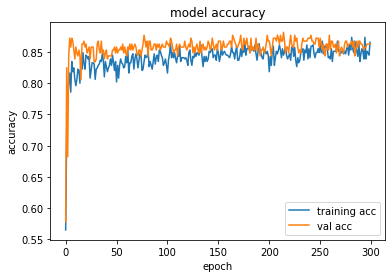

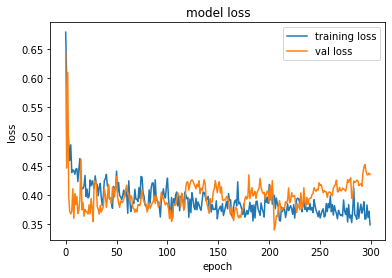

In [10]:

import matplotlib.pyplot as plt
fig = plt.figure()#新建一张图
model_id = 'final.h5'
plt.plot(history.history['accuracy'],label='training acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
fig.savefig('VGG16'+str(model_id)+'acc.png')
fig = plt.figure()
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
fig.savefig('VGG16'+str(model_id)+'loss.png')

In [11]:
model.save("final.h5")

Process testing data, similar to previous methods

In [12]:
def calcWeight(item):#这个函数用来计算单个人dic的权重 用来选择权重最高的那个人
    #身体25个关键点位 面部70个关键点位，每个点位按照x, y belief来决定
    zeros = 0
    for i in item['pose_keypoints_2d']:
        if i == 0:
            zeros += 1
    for i in item['face_keypoints_2d']:
        if i == 0:
            zeros +=1
    return zeros

def getJsonForOneFrame(fileName, filePath):#现在用来选择一个文件里权重最高的那个人，获取他的信息
    l = getJsonList(filePath)
    
    with open(fileName,'r') as f:
        temp = json.loads(f.read())
        allPeople = temp['people']#这是一个列表 列表里每一个文件是一个人的信息
    
    if len(allPeople) == 0:
        empty = []
        for i in range(190):
            empty.append(0)
        return empty
    target = allPeople[0]
    for dic in allPeople:
        if calcWeight(dic) < calcWeight(target):
            target = dic
    matrix = []
    if(len(target['pose_keypoints_2d']) == 0):
        for i in range(50):
            matrix.append(0)
    else:
        for i in range(75):
            if (i+1) % 3 == 0:
                pass
            else:
                matrix.append(target['pose_keypoints_2d'][i])
                
    if(len(target['face_keypoints_2d']) == 0):
        for i in range(140):
            matrix.append(0)
    else:
        for i in range(210):
            if (i+1) % 3 == 0:
                pass
            else:
                matrix.append(target['face_keypoints_2d'][i])
    return matrix


def writeData(path, pathType,fullDfList):
    fileList = getJsonList(path)
    fileList = set(fileList)
    print(len(fileList))
    dataCat = pd.read_csv('data.csv')#csv文件做成pandas data frame并返回
    for index, row in dataCat.iterrows():
        temp = int(row['name'][:-1])
        if(row["type"] != pathType):#在这里选择文件夹
            pass
        else:
            startName = row["name"]+"_"+'0'.zfill(12)+"_keypoints.json"
            endName = row["name"]+"_"+'30'.zfill(12)+"_keypoints.json"#初步选择窗口为30帧
            if endName and endName not in fileList:
                print('Video ',row["name"]," is not long enough")
            else:#这种情况下我们确认了这个文件在json和csv中能够对应上而且长度足够
                initFrame = 0
                while(row["name"]+"_"+str(initFrame + 29).zfill(12)+"_keypoints.json" in fileList):
                    matrix = []
                    for i in range(30):
                        file = row["name"]+"_"+str(initFrame + i).zfill(12)+"_keypoints.json"
                        matrixLine = getJsonForOneFrame(path+'/'+file,path)#这里选择大文件夹（我们现在有三个文件包）
                        matrix.append(matrixLine)
                    if row['type'] == 'shortyes':
                        label = True
                    elif row['type'] == 'shortno':
                        label = False
                    else:
                        label = getLable(dataCat,row['name'], initFrame)
                    data = [[label, matrix]]
                    print("Data:",label, row['name'], initFrame,'matrix:',len(matrix),len(matrix[0]))
                    df = pd.DataFrame(data,columns=['lable','matrix'])
                    fullDfList.append(df)
                    initFrame += 30
    return fullDfList

We can only predict a video at one time, type the name as videoName

In [13]:
def draw(videoName, modelName):
    #videoName = '6'#define your test video name here
    fileList = getJsonList(videoName)
    fileList = set(fileList)
    print(len(fileList))
    fullData = []
    initFrame = 0
    while(videoName+"_"+str(initFrame + 29).zfill(12)+"_keypoints.json" in fileList):
        matrix = []
        for i in range(30):
            file = videoName+"_"+str(initFrame + i).zfill(12)+"_keypoints.json"
            matrixLine = getJsonForOneFrame(videoName+'/'+file,videoName)#这里选择大文件夹（我们现在有三个文件包）
            #print(len(matrixLine))
            matrix.append(matrixLine)
        fullData.append(matrix)
        initFrame += 30
    def cleanX(raw):
        length = len(raw)
        temp = np.zeros((length, 30,190))
        for i in range(len(raw)):
            for j in range(30):
                for k in range(190):
                    temp[i][j][k] = raw[i][j][k]
            print("progress:{0}%".format(round((i + 1) * 100 / len(raw))), end="\r")
        return temp
    temp = cleanX(fullData)
    model = load_model(modelName)
    predict = model.predict_classes(temp)
    a = predict.tolist()
    result = [[0,0]]
    frames = 30
    for i in a:
        result.append([frames,a[0][0]])
        frames += 30
    print(result)

    # A chart is the container that your data will be rendered in, it can (obviously) support multiple data series within it.
    chart = Highchart()

    # Adding a series requires at minimum an array of data points. 
    # You can also change the series type, the name, or other series options as kwargs.
    chart.set_options('chart', {'inverted': False})

    options = {
        'title': {
            'text': 'Prediction for video '+videoName+'.mp4'
        },
        'subtitle': {
            'text': '1 means talking while 0 means non-talking'
        },
         'xAxis': {
            'title': {

                'text': 'Frames'
            }


        },
        'yAxis': {
            'title': {
                'text': 'Flag'
            },
        }
    }

    chart.set_dict_options(options)
    chart.add_data_set(result, series_type='line', name='prediction')
    return chart

In [14]:
chart1 = draw('1', 'final.h5')
chart1

1400
[[0, 0], [30, 1], [60, 1], [90, 1], [120, 1], [150, 1], [180, 1], [210, 1], [240, 1], [270, 1], [300, 1], [330, 1], [360, 1], [390, 1], [420, 1], [450, 1], [480, 1], [510, 1], [540, 1], [570, 1], [600, 1], [630, 1], [660, 1], [690, 1], [720, 1], [750, 1], [780, 1], [810, 1], [840, 1], [870, 1], [900, 1], [930, 1], [960, 1], [990, 1], [1020, 1], [1050, 1], [1080, 1], [1110, 1], [1140, 1], [1170, 1], [1200, 1], [1230, 1], [1260, 1], [1290, 1], [1320, 1], [1350, 1], [1380, 1]]


In [15]:
chart2 = draw('2', 'final.h5')
chart2

793
[[0, 0], [30, 0], [60, 0], [90, 0], [120, 0], [150, 0], [180, 0], [210, 0], [240, 0], [270, 0], [300, 0], [330, 0], [360, 0], [390, 0], [420, 0], [450, 0], [480, 0], [510, 0], [540, 0], [570, 0], [600, 0], [630, 0], [660, 0], [690, 0], [720, 0], [750, 0], [780, 0]]


In [18]:
chart3 = draw('3', 'final.h5')
chart3

964
[[0, 0], [30, 1], [60, 1], [90, 1], [120, 1], [150, 1], [180, 1], [210, 1], [240, 1], [270, 1], [300, 1], [330, 1], [360, 1], [390, 1], [420, 1], [450, 1], [480, 1], [510, 1], [540, 1], [570, 1], [600, 1], [630, 1], [660, 1], [690, 1], [720, 1], [750, 1], [780, 1], [810, 1], [840, 1], [870, 1], [900, 1], [930, 1], [960, 1]]


In [16]:
chart4 = draw('4', 'final.h5')
chart2

170
[[0, 0], [30, 1], [60, 1], [90, 1], [120, 1], [150, 1]]


In [17]:
chart5 = draw('8', 'final.h5')
chart5

2980
[[0, 0], [30, 1], [60, 1], [90, 1], [120, 1], [150, 1], [180, 1], [210, 1], [240, 1], [270, 1], [300, 1], [330, 1], [360, 1], [390, 1], [420, 1], [450, 1], [480, 1], [510, 1], [540, 1], [570, 1], [600, 1], [630, 1], [660, 1], [690, 1], [720, 1], [750, 1], [780, 1], [810, 1], [840, 1], [870, 1], [900, 1], [930, 1], [960, 1], [990, 1], [1020, 1], [1050, 1], [1080, 1], [1110, 1], [1140, 1], [1170, 1], [1200, 1], [1230, 1], [1260, 1], [1290, 1], [1320, 1], [1350, 1], [1380, 1], [1410, 1], [1440, 1], [1470, 1], [1500, 1], [1530, 1], [1560, 1], [1590, 1], [1620, 1], [1650, 1], [1680, 1], [1710, 1], [1740, 1], [1770, 1], [1800, 1], [1830, 1], [1860, 1], [1890, 1], [1920, 1], [1950, 1], [1980, 1], [2010, 1], [2040, 1], [2070, 1], [2100, 1], [2130, 1], [2160, 1], [2190, 1], [2220, 1], [2250, 1], [2280, 1], [2310, 1], [2340, 1], [2370, 1], [2400, 1], [2430, 1], [2460, 1], [2490, 1], [2520, 1], [2550, 1], [2580, 1], [2610, 1], [2640, 1], [2670, 1], [2700, 1], [2730, 1], [2760, 1], [2790, 1],